# pre-process h5 output to get river face flux

In [15]:
import numpy as np
import h5py as h5
import glob
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta

In [16]:
def batch_time_to_delta(origin, x, time_format):
    y = []
    for ix in x:
        temp_y = abs(datetime.strptime(
            ix, time_format) - origin).total_seconds()
        y.append(temp_y)
    y = np.asarray(y)
    return(y)

def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

In [17]:
#input
model_dir = "/Users/shua784/Paraview/HFR/HFR_200x200x2_1w_bc/"
out_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Outputs/HFR_model_200x200x2_1w_bc/"
result_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/results/HFR_model_200x200x2_1w_bc/"
data_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/data/"
fname_usgs_gage = data_dir + "USGS_flow_gh_12472800.csv"
#output
fname_pickle = result_dir + "face_flux.pk"
fig_face_flux = out_dir + "face_flux/face_flux.png"
fname_flux_net_gaining = out_dir + "face_flux/flux_net_gain.txt"
fname_flux_abs_exchange = out_dir + "face_flux/flux_abs_exchange.txt"
fname_flux_abs_gaining = out_dir + "face_flux/flux_abs_gain.txt"
fname_flux_abs_losing = out_dir + "face_flux/flux_abs_lose.txt"

In [6]:
material_h5 = h5.File(model_dir + "HFR_material_river.h5", "r")

all_h5 = glob.glob(model_dir + "pflotran*h5")
all_h5 = np.sort(all_h5)

In [7]:
input_h5 = h5.File(all_h5[0], "r")
x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])
input_h5.close()


In [8]:
dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

west_area = dy[0] * dz[0]
east_area = dy[0] * dz[0]
south_area = dx[0] * dz[0]
north_area = dx[0] * dz[0]
top_area = dx[0] * dy[0]
bottom_area = dx[0] * dy[0]

In [9]:
# read river face information
river_cells = []
river_faces = []
for i_region in list(material_h5['Regions'].keys()):
    river_cells = np.append(river_cells, np.asarray(
        list(material_h5["Regions"][i_region]["Cell Ids"])))
    river_faces = np.append(river_faces, np.asarray(
        list(material_h5["Regions"][i_region]["Face Ids"])))
river_cells = river_cells.astype(int)
river_cells = river_cells - 1  # need minus 1 as python index started with 0
river_faces = river_faces.astype(int)

unique_river_cells = np.unique(river_cells)

In [10]:
temp_unique_river_cells = unique_river_cells
unique_river_cells = []
for i_cell in temp_unique_river_cells:
    if (grids[i_cell, 0] > 0 and grids[i_cell, 0] < (nx - 1) and
            grids[i_cell, 1] > 0 and grids[i_cell, 1] < (ny - 1) and
            grids[i_cell, 2] > 0 and grids[i_cell, 2] < (nz - 1)):
        unique_river_cells.append(i_cell)

n_unique = len(unique_river_cells)
unique_index = [grids[i, :] for i in unique_river_cells]

In [12]:
unique_index

[array([216,   4,  45]),
 array([216,   5,  45]),
 array([216,   6,  45]),
 array([216,   7,  45]),
 array([217,   3,  46]),
 array([217,   4,  46]),
 array([217,   5,  46]),
 array([217,   6,  46]),
 array([217,   7,  46]),
 array([216,   8,  46]),
 array([217,   8,  46]),
 array([221,  36,  46]),
 array([221,  37,  46]),
 array([221,  38,  46]),
 array([221,  39,  46]),
 array([220,  42,  46]),
 array([220,  43,  46]),
 array([220,  44,  46]),
 array([219,  46,  46]),
 array([217,  49,  46]),
 array([216,  53,  46]),
 array([216,  54,  46]),
 array([215,  56,  46]),
 array([215,  57,  46]),
 array([216,  65,  46]),
 array([216,  66,  46]),
 array([216,  67,  46]),
 array([217,   2,  47]),
 array([218,   3,  47]),
 array([218,   4,  47]),
 array([217,   5,  47]),
 array([217,   6,  47]),
 array([217,   7,  47]),
 array([218,   8,  47]),
 array([216,   9,  47]),
 array([217,   9,  47]),
 array([216,  10,  47]),
 array([217,  10,  47]),
 array([216,  11,  47]),
 array([217,  11,  47]),


In [11]:
river_face_array = np.array([], dtype=np.float).reshape(0, 6)
for i_cell in unique_river_cells:
    temp_face_vector = np.array([0] * 6).reshape(1, 6)
    temp_faces = river_faces[river_cells == i_cell]
    for iface in list(map(int, temp_faces)):
        temp_face_vector[0, iface - 1] = 1
    river_face_array = np.concatenate(
        (river_face_array, temp_face_vector), axis=0)

In [13]:
out_flux = {}
all_h5 = glob.glob(model_dir + "pflotran*h5")
for i_h5 in all_h5:
    print(i_h5)
    h5file = h5.File(i_h5, "r")
    groups = list(h5file.keys())
    time_index = [i for i, s in enumerate(groups) if "Time:" in s]
    times = [groups[i] for i in time_index]
    for itime in times:
        print(itime)

        # get dict of all flux
        x_darcy = np.asarray(list(h5file[itime]["Liquid X-Flux Velocities"]))
        y_darcy = np.asarray(list(h5file[itime]["Liquid Y-Flux Velocities"]))
        z_darcy = np.asarray(list(h5file[itime]["Liquid Z-Flux Velocities"]))

        # get flux on all cell face in river bed cells
        west_flux = [x_darcy[i[0] - 1, i[1], i[2]] for i in unique_index] # why - 1 ?
        east_flux = [x_darcy[i[0], i[1], i[2]] for i in unique_index]
        south_flux = [y_darcy[i[0], i[1] - 1, i[2]] for i in unique_index]
        north_flux = [y_darcy[i[0], i[1], i[2]] for i in unique_index]
        bottom_flux = [z_darcy[i[0], i[1], i[2] - 1] for i in unique_index]
        top_flux = [z_darcy[i[0], i[1], i[2]] for i in unique_index]

        # get volumeric flux
        west_flux = [x * west_area for x in west_flux]
        east_flux = [x * east_area for x in east_flux]
        south_flux = [x * south_area for x in south_flux]
        north_flux = [x * north_area for x in north_flux]
        bottom_flux = [x * bottom_area for x in bottom_flux]
        top_flux = [x * top_area for x in top_flux]

        # get flux on river face of river cells
        river_face_flux = river_face_array * np.column_stack(
            (west_flux, east_flux, south_flux,
             north_flux, bottom_flux, top_flux))

        # combine x,y,z directions to get outflow flux
        out_flux[itime] = [(-x[0] + x[1] - x[2] + x[3] - x[4] + x[5])
                           for x in river_face_flux]
file = open(fname_pickle, "wb")
pickle.dump(out_flux, file)
file.close()

material_h5.close()

/Users/shua784/Paraview/HFR/HFR_200x200x2_1w_bc/pflotran_200x200x2_1w_bc.h5
Time:  3.24000E+04 h
Time:  3.25200E+04 h
Time:  3.26400E+04 h
Time:  3.27600E+04 h
Time:  3.28800E+04 h
Time:  3.30000E+04 h
Time:  3.31200E+04 h
Time:  3.32400E+04 h
Time:  3.33600E+04 h
Time:  3.34800E+04 h
Time:  3.36000E+04 h
Time:  3.37200E+04 h
Time:  3.38400E+04 h
Time:  3.39600E+04 h
Time:  3.40800E+04 h
Time:  3.42000E+04 h
Time:  3.43200E+04 h
Time:  3.44400E+04 h
Time:  3.45600E+04 h
Time:  3.46800E+04 h
Time:  3.48000E+04 h
Time:  3.49200E+04 h
Time:  3.50400E+04 h
Time:  3.51600E+04 h
Time:  3.52800E+04 h
Time:  3.54000E+04 h
Time:  3.55200E+04 h
Time:  3.56400E+04 h
Time:  3.57600E+04 h
Time:  3.58800E+04 h
Time:  3.60000E+04 h
Time:  3.61200E+04 h
Time:  3.62400E+04 h
Time:  3.63600E+04 h
Time:  3.64800E+04 h
Time:  3.66000E+04 h
Time:  3.67200E+04 h
Time:  3.68400E+04 h
Time:  3.69600E+04 h
Time:  3.70800E+04 h
Time:  3.72000E+04 h
Time:  3.73200E+04 h
Time:  3.74400E+04 h
Time:  3.75600E+04 h


# generate flux bar plot (abs. exchange, net exchange etc.)

In [18]:
# load pre-processed file
pickle_file = open(fname_pickle, "rb")
out_flux = pickle.load(pickle_file)
times = np.sort(list(out_flux.keys()))
simu_time = np.sort([np.float(i[5:19]) for i in times])  ## why i[5:19] ??

In [19]:
discharge_file = open(fname_usgs_gage, "r")
discharge_data = discharge_file.readlines()
discharge_data = [x.replace('"', "") for x in discharge_data]
discharge_data = [x.split(",") for x in discharge_data[1:]]
discharge_data = [list(filter(None, x)) for x in discharge_data]
discharge_data = np.asarray(discharge_data)
discharge_time = [datetime.strptime(x, "%Y-%m-%d")
                  for x in discharge_data[:, 3]]
discharge_value = discharge_data[:, 4]  # .astype(float)

In [20]:
date_origin = datetime.strptime("2007-03-28 00:00:00", "%Y-%m-%d %H:%M:%S")
real_time = batch_delta_to_time(
    date_origin, simu_time, "%Y-%m-%d %H:%M:%S", "hours")
real_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_time]

time_ticks = [
    "2011-01-01 00:00:00",
    "2012-01-01 00:00:00",
    "2013-01-01 00:00:00",
    "2014-01-01 00:00:00",
    "2015-01-01 00:00:00",
    "2016-01-01 00:00:00"]
time_ticks = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in time_ticks]

In [22]:
n_segment = len(time_ticks) - 1 # num of intervals
sum_flow = np.array([0.] * n_segment)
abs_flow = np.array([0.] * n_segment)
out_flow = np.array([0.] * n_segment)
in_flow = np.array([0.] * n_segment)
for i_segment in range(n_segment):
    select_index = []
    for i_index in range(len(real_time)):
        if (real_time[i_index] >= time_ticks[i_segment] and
                real_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    for i_index in select_index:
        temp_flux = np.asarray(out_flux[times[i_index]])
        sum_flow[i_segment] = sum_flow[i_segment] + np.sum(temp_flux)
        abs_flow[i_segment] = abs_flow[i_segment] + np.sum(np.abs(temp_flux))
        out_flow[i_segment] = out_flow[i_segment] + \
            sum(temp_flux[temp_flux >= 0])
        in_flow[i_segment] = in_flow[i_segment] + \
            sum(temp_flux[temp_flux <= 0])
    sum_flow[i_segment] = sum_flow[i_segment] / len(select_index)
    abs_flow[i_segment] = abs_flow[i_segment] / len(select_index)
    out_flow[i_segment] = out_flow[i_segment] / len(select_index)
    in_flow[i_segment] = in_flow[i_segment] / len(select_index)

sum_flow = sum_flow * 365.25 * 24
abs_flow = abs_flow * 365.25 * 24
out_flow = out_flow * 365.25 * 24
in_flow = in_flow * 365.25 * 24

In [23]:
discharge_flow = np.array([0.] * n_segment)
for i_segment in range(n_segment):
    select_index = []
    for i_index in range(len(discharge_time)):
        if (discharge_time[i_index] >= time_ticks[i_segment] and
                discharge_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    sum_discharge = sum(np.asarray([discharge_value[i]
                                    for i in select_index]).astype(float))
    sum_discharge = sum_discharge * 3600 * 24 * (0.3048**3)
    discharge_flow[i_segment] = sum_discharge

## plot absolute exchange and net exchange 

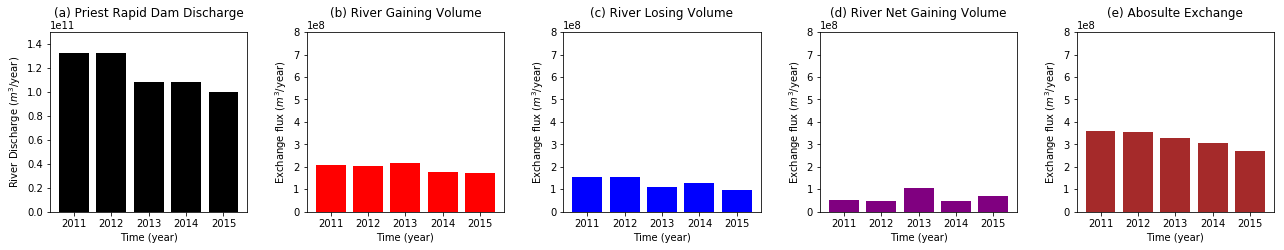

In [24]:
start_year = 2011
fig_name = fig_face_flux
gs = gridspec.GridSpec(1, 5)
fig = plt.figure()

ax0 = fig.add_subplot(gs[0, 0])
ax0.bar(start_year + np.arange(n_segment), discharge_flow, color="black")
ax0.set_ylim([0, 1.5e11])
ax0.set_xlabel('Time (year)')
ax0.set_ylabel('River Discharge ($m^3$/year)')
ax0.set_title("(a) Priest Rapid Dam Discharge", y=1.05)

ax1 = fig.add_subplot(gs[0, 1])
ax1.bar(start_year + np.arange(n_segment), out_flow, color="red")
ax1.set_ylim([0, 8e8])
ax1.set_xlabel('Time (year)')
ax1.set_ylabel('Exchange flux ($m^3$/year)')
ax1.set_title("(b) River Gaining Volume", y=1.05)

ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(start_year + np.arange(n_segment), -in_flow, color="blue")
ax2.set_ylim([0, 8e8])
ax2.set_xlabel('Time (year)')
ax2.set_ylabel('Exchange flux ($m^3$/year)')
ax2.set_title("(c) River Losing Volume", y=1.05)

ax3 = fig.add_subplot(gs[0, 3])
ax3.bar(start_year + np.arange(n_segment), sum_flow, color="purple")
ax3.set_ylim([0, 8e8])
ax3.set_xlabel('Time (year)')
ax3.set_ylabel('Exchange flux ($m^3$/year)')
ax3.set_title("(d) River Net Gaining Volume", y=1.05)

ax4 = fig.add_subplot(gs[0, 4])
ax4.bar(start_year + np.arange(n_segment), abs_flow, color="brown")
ax4.set_ylim([0, 8e8])
ax4.set_xlabel('Time (year)')
ax4.set_ylabel('Exchange flux ($m^3$/year)')
ax4.set_title("(e) Abosulte Exchange", y=1.05)

fig.tight_layout()
fig.subplots_adjust(left=0.1,
                    right=0.95,
                    bottom=0.07,
                    top=0.85,
                    wspace=0.30,
                    hspace=0.38
                    )
fig.set_size_inches(20, 3.2)

In [25]:
fig.savefig(fig_face_flux, dpi=600, transparent=True)
plt.close(fig)

## save raw data

In [26]:
bar_file = open(fname_flux_net_gaining, 'w')
for i_flow in sum_flow:
    bar_file.write("%3.2e\n" % i_flow)
bar_file.close()

bar_file = open(fname_flux_abs_exchange, 'w')
for i_flow in abs_flow:
    bar_file.write("%3.2e\n" % i_flow)
bar_file.close()

bar_file = open(fname_flux_abs_losing, 'w')
for i_flow in in_flow:
    bar_file.write("%3.2e\n" % -i_flow)
bar_file.close()

bar_file = open(fname_flux_abs_gaining, 'w')
for i_flow in out_flow:
    bar_file.write("%3.2e\n" % i_flow)
bar_file.close()